# Evaluating PQCs

To train the **PQCS** (see notebook *16_qml4var_BuildPQC.ipynb*) using a dataset (see *15_qml4var_DataSets.ipynb*) it is mandatory to design a workflow that evaluates the **PQC**, for a fixed set of trainable parameters $\theta$, in the input features of the dataset.

Present notebook reviews the mandatory functions for building this workflow.

To train the **PQC** (refer to the notebook 16_qml4var_BuildPQC.ipynb) using a dataset (from 15_qml4var_DataSets.ipynb), it is essential to design a workflow that evaluates the **PQC** at different input features of the dataset for a given set of trainable parameters $\theta$. This notebook outlines the required functions for constructing this evaluation workflow.

In [1]:
import sys 
import json
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Get some dataset

First, some dataset for evaluating the **PQC** is needed. A random dataset will be generated using the *create_random_data* from **benchmark.qml4var.data_sets** module

In [2]:
from benchmark.qml4var.data_sets import create_random_data

Text(0.5, 1.0, 'Random Dataset')

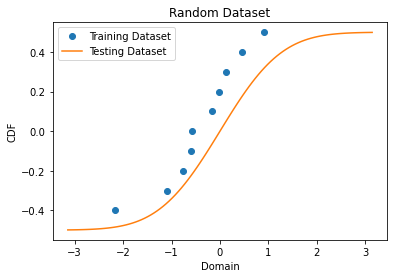

In [3]:
cfg_random = {
    "n_points_train": 10, 
    "n_points_test" : 100,
    "minval" : -np.pi,
    "maxval" : np.pi,
    "features_number" : 1
}
x_train, y_train, x_test, y_test = create_random_data(
    **cfg_random
)
plt.plot(x_train, y_train, "o")
plt.plot(x_test, y_test, "-")
plt.xlabel("Domain")
plt.ylabel("CDF")
plt.legend(["Training Dataset", "Testing Dataset"])
plt.title("Random Dataset")

## 2. Build the PQC

The *hardware_efficient_ansatz* and the *z_observable* from **QQuantLib.qml4var.architectures** modules will be used to build the **PQC**. Additionally, the *normalize_data* function will be used for data normalization between $\frac{-\pi}{2}$ and $\frac{\pi}{2}$.



In [4]:
from QQuantLib.qml4var.architectures import hardware_efficient_ansatz, z_observable, normalize_data

In [5]:
pqc_cfg = {
    "features_number" : cfg_random["features_number"],
    "n_qubits_by_feature" : 2,
    "n_layers": 3    
}
# Normalization function
base_frecuency, shift_feature = normalize_data(
    [cfg_random["minval"]] * cfg_random["features_number"],
    [cfg_random["maxval"]] * cfg_random["features_number"],
    [-0.5*np.pi] * cfg_random["features_number"],
    [0.5*np.pi] * cfg_random["features_number"]   
)
pqc_cfg.update({
    "base_frecuency" : base_frecuency,
    "shift_feature" : shift_feature    
})   
print(pqc_cfg)
pqc, weights_names, features_names = hardware_efficient_ansatz(**pqc_cfg)
observable = z_observable(**pqc_cfg)

{'features_number': 1, 'n_qubits_by_feature': 2, 'n_layers': 3, 'base_frecuency': array([0.5]), 'shift_feature': array([0.])}


In [6]:
# plot PQC
circuit = pqc.to_circ()
circuit.display()

## 3. PQC single evaluation using stack of Plugins

This sections explains how to evaluate the **PQC** ($F^*(\textbf{x}, \theta)$), for a fixed set of weights, $\theta$, for a single input $\tilde{\textbf{x}}$. So we want to compute: $F^*(\tilde{\textbf{x}}, \theta)$.

A function that executes the following workflow is needed:

1. Assigns the $\theta$ to the **weights**  parameters of the **PQC**.
2. Assings the input sample $\tilde{\textbf{x}}$ to the **features** parameters of the **PQC**
3. Execute (or simulate) the obtained quantum circuit
4. Return the expected value of the  **PQC** under the desired **Observable**.

To implement this workflow in **EVIDEN myqlm** we will use the stack of Plugins concept. 

The stack is a complete set of **myQLM Plugins (https://myqlm.github.io/02_user_guide/02_execute/04_plugin.html)**  that can process a flow of quantum jobs on their way to **Quantum Process Unit (QPU)** and/or process a flow of information (samples or values) on their way back from a **QPU**.

### 3.1 QPU configuration

To build a complete **myqlm Pluging stack** a **myqlm QPU** is mandatory. The following cells show how to configure and instantiate a **myqlm QPU** (see *00_AboutTheNotebooksAndQPUs*).

Here we use a JSON configuration file found in the **benchmark/qml4var/JSONs/** folder of the *FinancialApplications* software package.

In [7]:
from QQuantLib.utils.benchmark_utils import combination_for_list
from QQuantLib.qpu.select_qpu import select_qpu

In [8]:
json_qpu = "../../benchmark/qml4var/JSONs/qpu_ideal.json"
with open(json_qpu) as json_file:
    qpu_dict = json.load(json_file)
qpu_list = combination_for_list(qpu_dict)
qpu_dict = qpu_list[0]
print(qpu_dict)

{'qpu_type': 'c', 't_gate_1qb': None, 't_gate_2qbs': None, 't_readout': None, 'depol_channel': {'active': False, 'error_gate_1qb': None, 'error_gate_2qbs': None}, 'idle': {'amplitude_damping': False, 'dephasing_channel': False, 't1': None, 't2': None}, 'meas': {'active': False, 'readout_error': None}}


In [9]:
# Get the QPU
qpu = select_qpu(qpu_dict)

### 3.2 Building the Plugin stack

To build the stack of **myqlm Plugins** we are going to use different homemade Plugins found in the **QQuantLib.qml4var.plugins** module.


The *SetParametersPlugin* plugin is the most important one because it allows us to fix the *weights* and the *features* for all the **PQC**s from a Batch of myqlm jobs.

Additionally, we are going to use the *ViewPlugin* that allows to print the circuits in one part of the stack.

In [10]:
from QQuantLib.qml4var.plugins import SetParametersPlugin, ViewPlugin

/mnt/netapp1/Optcesga_FT2_RHEL7/2022/gentoo/31032022/usr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The *SetParametersPlugin* needs as inputs the desired weights and the features for evaluating the **PQC**.

In [11]:
# Set some random weights
weights_ = [np.random.rand() for w in weights_names]
print("weights_: {}".format(weights_))
# print select a input for evaluating the PQC
sample_ = x_train[0]
print("sample_: {}".format(sample_))

weights_: [0.008657679704434984, 0.0554470429428402, 0.9926579349603675, 0.5164762815500884, 0.46577288251121296, 0.8779998209073178]
sample_: [0.44712309]


Now the plugin stack will be built by including the QPU object at the end.

In [12]:
stack_ = SetParametersPlugin(weights_, sample_) | ViewPlugin("SetParametersPlugin") | qpu

### 3.3 Execute the Pluging stack

Finally, we can use the built stack to evaluate a **Batch** of **myQLM Jobs**.

In [13]:
from qat.core import Batch

In [14]:
#first: build quantum circuit from PQC
circuit = pqc.to_circ()
#second: build the job with the observable
job = circuit.to_job(nbshots=0, observable=observable)
#third: build the Batch of jobs with the observable
batch_ = Batch(jobs=[job])

In [15]:
# input circuit
circuit.display()

To properly use the built stack (with the *SetParametersPlugin*) on a **myQLM Batch**, some information must be provided. In this case, it is mandatory to indicate which parameters of the PQC are related to the **weights** and which are related to the input **features**.

This information should be provided as a Python dictionary to the *meta_data* attribute of the batch, as shown in the following cell.

In [16]:
batch_.meta_data = {
    "weights" : weights_names, # PQC parameters related with weights
    "features" : features_names # PQC parameters related with features
}
#fourth using stack to execute the batch_
results = stack_.submit(batch_)

Quantum Circuits from Pluging: SetParametersPlugin 



None


In the preceding cell, the *ViewPlugin* plots the quantum circuit resulting from the SetParametersPlugin. As can be seen, this plugin has replaced the parameters of the initial quantum circuit with the ones provided to the plugin.

The evaluation of the job can be found in the *value* attribute of the corresponding **myQLM Result** (the first one in this case) within the returned **myQLM BatchResult**.

In [17]:
print("For weights: {}".format(weights_))
print("And for input :{}".format(sample_))
print("The evaluation of the PQC is: {}".format(results[0].value))

For weights: [0.008657679704434984, 0.0554470429428402, 0.9926579349603675, 0.5164762815500884, 0.46577288251121296, 0.8779998209073178]
And for input :[0.44712309]
The evaluation of the PQC is: 0.5410425377431323


Python lambda functions can be used to add more versatility to the plugins!

In [18]:
# First the weights and features can be passed as lambda input variables
# Second the complete stack is built
stack_2 = lambda weights, features: \
    SetParametersPlugin(weights, features) | qpu

In [19]:
print("Evaluation for: {} is {}".format(
    x_train[2], 
    stack_2(weights_, x_train[2]).submit(batch_)[0].value
))
print("Evaluation for: {} is {}".format(
    x_train[4], 
    stack_2(weights_, x_train[4]).submit(batch_)[0].value
))

Evaluation for: [-0.60338961] is 0.5083942114299942
Evaluation for: [-0.1575376] is 0.7379518405672245


### 3.4 Building stack for PDF evaluation (the pdfPluging Plugin)

We can extend the plugin stack to easily evaluate the **PDF** of an input **PQC**.

As explained in *16_qml4var_BuildPQC*, in addition to a **PQC** for computing the **CDF**, $F^*(\textbf{x}, \theta)$, our training workflow will also need to compute the corresponding **PDF** of the **CDF**:


$$f^*(\textbf{x}, \theta) = \frac{\partial^m F^*(\textbf{x}, \theta)}{\partial x_{m-1} \cdots \partial x_1 \partial x_0}$$

In the notebook *16_qml4var_BuildPQC*, the *compute_pdf_from_pqc* function from the **QQuantLib.qml4var.architectures** module was used to generate the quantum circuits required for computing this **PDF**.

Here, we will take a different approach: we will build a new stack of plugins that includes the *pdfPlugin* from the **QQuantLib.qml4var.plugins** module. This *pdfPlugin* converts *compute_pdf_from_pqc* into a **myQLM Plugin** that can be added to a stack. The resulting stack will generate all the necessary quantum circuits for computing the desired **PDF**.

The *pdfPlugin* requires the **PQC** feature names as input.

In [20]:
from QQuantLib.qml4var.plugins import pdfPluging

In [21]:
# Creates the stack for PDF computations
# Here we use the ViewPlugin to see the quantum circuits mandatory for PDF computation
stack_pdf = lambda weights, features: \
    pdfPluging(features_names) | ViewPlugin("pdfPluging") | SetParametersPlugin(weights, features) | qpu

In [22]:
result_pdf = stack_pdf(weights_, sample_).submit(batch_)

Quantum Circuits from Pluging: pdfPluging 



None


None


None


None


None


None


None


None


None


None


None


None


As can be seen, the *ViewPlugin* allows us to see which quantum circuits should be generated for building **PDF** evaluation.

As usual, the output of the stack_execution is a **myQLM BatchResult**. The value attribute of the first element of the **BatchResult** contains the desired **PDF** value. In the *meta_data* attribute, we can see the measurements for all the built circuits.


In [23]:
print("The evaluation of the PDF  using the PQC for the input {} is {}".format(
    sample_, result_pdf[0].value))

The evaluation of the PDF  using the PQC for the input [0.44712309] is -0.8485789763257936


In [24]:
print("The evaluation of all the generated circuits:\n {}".format(result_pdf[0].meta_data))

The evaluation of all the generated circuits:
 {'output': array([-0.10158109, -0.07751247, -0.1288218 , -0.08370446,  0.11402043,
       -0.21346468, -0.10218494, -0.07163637, -0.0918468 , -0.0918468 ,
        0.13526063, -0.13526063])}


## 4. The myqlm_workflows module

The **QQuantLib.qml4var.myqlm_workflows** module is the central module used for building the different workflows mandatory for building a complete training process for **PQC**s.

This module contains several functions that allows to the user build the workflow for evaluating quantum circuits in **myQLM** using the concepts of a stack of plugins easily.


### 4.1 The stack_execution Function

The *stack_execution* function from **QQuantLib.qml4var.myqlm_workflows** is the central function of this module and automates the previously described workflow for a given plugin stack.

The main inputs of the function are:

* weights : The weights for the **PQC** ($\theta$).
* x_sample : The desired sample input ($\tilde{\textbf{x}}$).
* stack : A group of myQLM plugins that enables **PQC** evaluation. 
* kwargs : Keyword arguments with additional information. Mandatory  keywords:
    * pqc: The value MUST BE the **myQLM Program** that implements the desired PQC.
    * observable: The value MUST BE the **myQLM Observable** for the PQC.
    * weights_names: The value MUST BE a list of all the parameter names of the **PQC** related to the weights.
    * features_names: The value MUST BE a list of all the parameter names of the **PQC** related to the features.
    * nbshots: The number of shots for evaluating the **PQC**.
    
The return of the **stack_execution** will be a **myQLM BatchResult**.


In [25]:
from QQuantLib.qml4var.myqlm_workflows import stack_execution

To the *stack_execution* a properly configured stack should be provided:

In [26]:
nbshots = 0
# Configuring the workflow
workflow_cfg = {
    "pqc" : pqc,
    "observable" : observable,
    "weights_names" : weights_names,
    "features_names" : features_names,
    "nbshots" : nbshots,
}
# The stack for computing CDF is sending to the stack_execution function
result = stack_execution(weights_, sample_, stack_2, **workflow_cfg)
print("The evaluation of the PQC for the input {} is {}".format(sample_, result[0].value))
print("When the weights of the PQC were fixed to: {}".format(weights_))

The evaluation of the PQC for the input [0.44712309] is 0.5410425377431323
When the weights of the PQC were fixed to: [0.008657679704434984, 0.0554470429428402, 0.9926579349603675, 0.5164762815500884, 0.46577288251121296, 0.8779998209073178]


In [28]:
nbshots = 0
# Configuring the workflow
workflow_cfg = {
    "pqc" : pqc,
    "observable" : observable,
    "weights_names" : weights_names,
    "features_names" : features_names,
    "nbshots" : nbshots,
}
# The stack for computing PDF is sending to the stack_execution function
result = stack_execution(weights_, sample_, stack_pdf, **workflow_cfg)
print("The evaluation of the PQC for the input {} is {}".format(sample_, result[0].value))
print("When the weights of the PQC were fixed to: {}".format(weights_))

Quantum Circuits from Pluging: pdfPluging 

{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
{'gradient_circuit': False}


None
The evaluation of the PQC for the input [0.44712309] is -0.8485789763257936
When the weights of the PQC were fixed to: [0.008657679704434984, 0.0554470429428402, 0.9926579349603675, 0.5164762815500884, 0.46577288251121296, 0.8779998209073178]


### 4.2 the cdf_workflow Function

The *cdf_workflow* function, from **QQuantLib.qml4var.myqlm_workflows** module, automates the complete mandatory workflow for evaluating a **PQC**. This function selects the **QPU** (by providing the configuration), builds the desired **myQLM** stack, and submits the generated batch to it. The main inputs of the function are:

* weights: The weights for the **PQC**.
* x_sample: The desired sample input ($\vec{x}$).
* kwargs: Keyword arguments with additional information. Mandatory keywords:
    * *pqc*: The value MUST BE the **myQLM Program** that implements the desired **PQC**.
    * *observable*: The value MUST BE **myQLM Observable** for the **PQC**.
    * *weights_names*: The value MUST BE a list with the names of all the parameters of the **PQC** related to the **weights**.
    * *features_names*: The value MUST BE a list with the names of all the parameters of the **PQC** related to the **features**.
    * *nbshots*: The number of shots for evaluating the **PQC**
    * *qpu_info*: QPU configuration dictionary
    
The return of the function is the evaluation of the PQC using the provided features and weights.

In [30]:
from QQuantLib.qml4var.myqlm_workflows import cdf_workflow

In [31]:
workflow_cfg = {
    "pqc" : pqc,
    "observable" : observable,
    "weights_names" : weights_names,
    "features_names" : features_names,
    "nbshots" : nbshots,
    "qpu_info" : qpu_dict
}

In [32]:
value_ = cdf_workflow(weights_, sample_, **workflow_cfg)

In [33]:
print("The evaluation of the PQC for the input {} is {}".format(sample_, value_))
print("When the weights of the PQC were fixed to: {}".format(weights_))

The evaluation of the PQC for the input [0.44712309] is 0.5410425377431323
When the weights of the PQC were fixed to: [0.008657679704434984, 0.0554470429428402, 0.9926579349603675, 0.5164762815500884, 0.46577288251121296, 0.8779998209073178]


### 4.2 the pdf_workflow Function

The *pdf_workflow* function, from **QQuantLib.qml4var.qlm_procces** module, automates the complete mandatory workflow for evaluating the **PDF** of a given **PQC**. This function selects the **QPU** (by providing the configuration), builds the desired QLM stack, and submits the generated batch to it. The main inputs of the function are:

* weights: The weights for the **PQC**.
* x_sample: The desired sample input ($\vec{x}$).
* kwargs: Keyword arguments with additional information. Mandatory keywords:
    * *pqc*: The value MUST BE the **myQLM Program** that implements the desired **PQC**.
    * *observable*: The value MUST BE **myQLM Observable** for the **PQC**.
    * *weights_names*: the value MUST BE a list with the names of all the parameters of the **PQC** related to the **weights**.
    * *features_names*: the value MUST BE a list with the names of all the parameters of the **PQC** related to the **features**.
    * *nbshots* : The number of shots for evaluating the **PQC**.
    * *qpu_info* : **QPU** configuration dictionary
    
The return of the function is the evaluation of the **PDF** using the provided **features** and **weights**.

In [34]:
from QQuantLib.qml4var.myqlm_workflows  import pdf_workflow

In [35]:
value_pdf = pdf_workflow(weights_, sample_, **workflow_cfg)

In [36]:
value_pdf

-0.8485789763257936

In the following cells the *cdf_workflow* and the *pdf_workflow* are used for a more complex **PQC** architecture.

In [37]:
# Test PQC
test_pqc_dict = {
    'features_number': 2,
    'n_qubits_by_feature': 3,
    'n_layers': 4, 
}

# Get Normalization function
test_base_frecuency, test_shift_feature =normalize_data(
    [-np.pi] * test_pqc_dict["features_number"],
    [np.pi] * test_pqc_dict["features_number"],
    [-0.5*np.pi] * test_pqc_dict["features_number"],
    [0.5*np.pi] * test_pqc_dict["features_number"],    
)
# Update with the normalization
test_pqc_dict.update({
    "base_frecuency" : test_base_frecuency,
    "shift_feature" : test_shift_feature
})
# Create test pqc
test_pqc, test_weights_names, test_features_names = hardware_efficient_ansatz(
    **test_pqc_dict
)
# Create test Observable
test_observable = z_observable(**test_pqc_dict)

test_workflow_cfg = {
    "pqc" : test_pqc,
    "observable" : test_observable,
    "weights_names" : test_weights_names,
    "features_names" : test_features_names,
    "nbshots" : 0,
    "qpu_info" : qpu_dict    
}



test_circuit = test_pqc.to_circ()
test_circuit.display()

weights_test = [np.random.rand() for w in test_weights_names]
data_test = np.array([[-0.5, 0.2]])
sample_test = data_test[0]

In [38]:
value_cdf_test = cdf_workflow(weights_test, sample_test, **test_workflow_cfg)
print("CDF _evaluation: {}".format(value_cdf_test))
value_pdf_test = pdf_workflow(weights_test, sample_test, **test_workflow_cfg)
print("PDF _evaluation: {}".format(value_pdf_test))

CDF _evaluation: 0.21941872368351573
PDF _evaluation: 0.29960608486776763


### 4.3 The workflow_execution function

Now we need to compute the **CDF** and the **PDF** for all the samples in the dataset, given a complete input dataset (i.e., ${\tilde{\textbf{x}}^j, j=0, 1, \cdots, m-1}$, where $m$ is the number of samples in the dataset).

To do this, the *workflow_execution* function from the **QQuantLib.qml4var.myqlm_workflows** module can be used. This function receives the **weights**, the complete input dataset, and a properly configured workflow (such as *cdf_workflow* or *pdf_workflow*) to compute the corresponding evaluations of the **CDF** or the **PDF** using the **PQC**.


In [39]:
from QQuantLib.qml4var.myqlm_workflows import workflow_execution

In [40]:
# First configure porperly the desired workflow computation

# for computing CDF using PQC
cdf_workflow_ = lambda w,x : cdf_workflow(w, x, **workflow_cfg)
# for computing PDF using PQC
pdf_workflow_ = lambda w,x : pdf_workflow(w, x, **workflow_cfg)

In [41]:
%%time
cdf_prediction = workflow_execution(weights_, x_train, cdf_workflow_)
pdf_prediction = workflow_execution(weights_, x_train, pdf_workflow_)

CPU times: user 954 ms, sys: 8.79 ms, total: 963 ms
Wall time: 691 ms


In [42]:
cdf_prediction

[0.5410425377431323,
 0.7264441962371805,
 0.5083942114299942,
 0.5325657685498171,
 0.7379518405672245,
 0.03843830456456593,
 0.7510822791782981,
 0.37970379822912764,
 -0.11518691534930342,
 0.1267773550719657]

In [43]:
pdf_prediction

[-0.8485789763257936,
 -0.30428225687459703,
 0.735023230401191,
 0.7138633861471773,
 0.21441480143600022,
 -1.225895466644509,
 -0.03399774140969125,
 0.79335246244621,
 -0.1623697298068293,
 0.6947023667827015]

#### Using a Dask client. 

When the number of samples in the input dataset is high the evaluation can be time-consuming. If the user has access to a Dask cluster these evaluations can be submitted to the cluster in parallel achieving a high speed up. For doing this the only thing to do is provide the Dask client to the *workflow_execution*. In this case, the return are a list of *futures* so a list should provided to the gather method of the dask client to retrieve the desired result

**BE AWARE**

The following cells should be executed only if a Dask cluster is available

In [44]:
from distributed import Client
path_to_schedule_json = "/home/cesga/gferro/Codigo/qlm_cVar/dask_cluster_ft3/scheduler_info.json"
#path_to_schedule_json = "/home/cesga/gferro/Codigo/dask_cluster_ft3/scheduler_info.json"
client = Client(
    scheduler_file = path_to_schedule_json,
)

In [45]:
%%time
cdf_prediction_fut = workflow_execution(weights_, x_train, cdf_workflow_, client)
pdf_prediction_fut = workflow_execution(weights_, x_train, pdf_workflow_,client)
cdf_prediction_ = client.gather(cdf_prediction_fut)
pdf_prediction_ = client.gather(pdf_prediction_fut)

CPU times: user 21.5 ms, sys: 1.92 ms, total: 23.4 ms
Wall time: 169 ms


In [46]:
# This is a list of futures
cdf_prediction_fut

[<Future: finished, type: float, key: lambda-f3a83f70-3c03-40a5-a95b-b2ffa12e8526>,
 <Future: finished, type: float, key: lambda-8a330ac2-0e7c-441b-8567-44bcf52d96f0>,
 <Future: finished, type: float, key: lambda-93030b6e-3ac1-465c-b216-d16ff89a0548>,
 <Future: finished, type: float, key: lambda-d2d8a011-c8f8-4806-8002-d7d0ce5cf9d4>,
 <Future: finished, type: float, key: lambda-8165a03b-36d9-44a3-8ab7-2f6300c16ecf>,
 <Future: finished, type: float, key: lambda-50220b0d-e5c9-4352-94f7-08d61b2ea8de>,
 <Future: finished, type: float, key: lambda-916e3f73-d80c-4929-8ddb-d8620fab32bf>,
 <Future: finished, type: float, key: lambda-c9d6a6d5-8b78-4164-b68c-ddd1a1797c65>,
 <Future: finished, type: float, key: lambda-977a909c-2fba-4956-ac47-28722909b59d>,
 <Future: finished, type: float, key: lambda-e80b9c2b-9657-4d15-bed3-94f6a5d8b8b8>]

In [47]:
# This is the result of gather the futures so this is the desired result
cdf_prediction_

[0.5410425377431323,
 0.7264441962371806,
 0.5083942114299942,
 0.5325657685498171,
 0.7379518405672245,
 0.03843830456456593,
 0.7510822791782981,
 0.37970379822912764,
 -0.11518691534930339,
 0.1267773550719657]

###  4.4 *workflow_for_cdf* and *workflow_for_pdf* functions.

The *workflow_for_cdf* and *workflow_for_pdf* functions from **QQuantLib.qml4var.myqlm_workflows** build the before presented workflows for computing respectively **CDF** and **PDF** straightforwardly. 

The inputs are:

* weights: numpy array with weights for PQC ($\theta$)
* data_x: numpy array with dataset of the features
* kwargs: keyword arguments:
    * *pqc*: The value MUST BE the **myQLM Program** that implements the desired **PQC**.
    * *observable*: The value MUST BE **myQLM Observable** for the **PQC**.
    * *weights_names*: the value MUST BE a list with the names of all the parameters of the **PQC** related to the **weights**.
    * *features_names*: the value MUST BE a list with the names of all the parameters of the **PQC** related to the **features**.
    * *nbshots* : The number of shots for evaluating the **PQC**.
    * *qpu_info* : **QPU** configuration dictionary

The output will be a Python dictionary with the results:

* The *workflow_for_cdf* output will have a key *y_predict_cdf* with the desired results.
* The *workflow_for_pdf* output will have a key *y_predict_pdf* with the desired results.

In [48]:
from QQuantLib.qml4var.myqlm_workflows import workflow_for_cdf, workflow_for_pdf

In [49]:
cdf_value = workflow_for_cdf(weights_, x_train, **workflow_cfg)
pdf_value = workflow_for_pdf(weights_, x_train, **workflow_cfg)

In [50]:
print(cdf_value)

{'y_predict_cdf': array([ 0.54104254,  0.7264442 ,  0.50839421,  0.53256577,  0.73795184,
        0.0384383 ,  0.75108228,  0.3797038 , -0.11518692,  0.12677736])}


In [51]:
print(pdf_value)

{'y_predict_pdf': array([-0.84857898, -0.30428226,  0.73502323,  0.71386339,  0.2144148 ,
       -1.22589547, -0.03399774,  0.79335246, -0.16236973,  0.69470237])}


#### 4.2.1 Using a DASK cluster

To the arguments of the *workflow_for_cdf* and *workflow_for_pdf* functions a *DASK* client can be provided to speed up the computations. In this case,  the computations will be sent to the *DASK* cluster and the results retrieved transparently for the user.

**BE AWARE**

The following cells should be executed only if a Dask cluster is available

In [52]:
cdf_value_dask = workflow_for_cdf(weights_, x_train, dask_client=client, **workflow_cfg)
pdf_value_dask = workflow_for_pdf(weights_, x_train, dask_client=client, **workflow_cfg)

In [53]:
# Now the results are not futures anymore, they are the desired numpy array
cdf_value_dask

{'y_predict_cdf': array([ 0.54104254,  0.7264442 ,  0.50839421,  0.53256577,  0.73795184,
         0.0384383 ,  0.75108228,  0.3797038 , -0.11518692,  0.12677736])}

In [54]:
pdf_value_dask

{'y_predict_pdf': array([-0.84857898, -0.30428226,  0.73502323,  0.71386339,  0.2144148 ,
        -1.22589547, -0.03399774,  0.79335246, -0.16236973,  0.69470237])}